# mount drive

In [ ]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Mounted at /content/drive


In [ ]:
# import packages
import datetime
import holidays
import itertools
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

### 実験1
各時点より過去のデータで，座標，方角，曜日，時間，分ごとの平均を取って特徴量とする  
012-4にカラムのダブりがあったので修正

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [ ]:
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainデータをwide formatに変換
wide_train = pd.pivot(train, index="time", columns=["x", "y", "direction"], values="congestion")

# 曜日，時間，分のカラムを作成
wide_train = wide_train.reset_index()
wide_train["weekday"] = wide_train.time.dt.weekday
wide_train["hour"] = wide_train.time.dt.hour
wide_train["minute"] = wide_train.time.dt.minute

# 曜日，時間，分のループ用配列
weekdays = wide_train.weekday.unique()
hours = wide_train.hour.unique()
minutes = wide_train.minute.unique()

# 平均値の格納用配列 (あとでNaNを代入することになるのでfloat指定)
tmp = np.zeros_like(wide_train.loc[:, [0, 1, 2]]).astype("float")

# 曜日，時間，分の組み合わせでループして，各時点より過去のデータでの平均を計算
for wd, h, m in itertools.product(weekdays, hours, minutes):
    df = wide_train[(wide_train.weekday == wd) & (wide_train.hour == h) & (wide_train.minute == m)].loc[:, [0, 1, 2]]
    df = df.shift(1).cumsum() / np.repeat(np.arange(df.shape[0]).reshape((-1, 1)), df.shape[1], axis=1)
    tmp[df.index, :] = df.values

# "wd_h_min_mean"というカラムをtrain setに追加
tmp = pd.DataFrame(tmp, index=wide_train.time, columns=wide_train.columns[1:-3])
tmp = tmp.stack(["x", "y", "direction"])
tmp.name = "wd_h_min_mean"
train = train.merge(tmp, how="left", left_on=["time", "x", "y", "direction"], right_index=True)

In [ ]:
# train, testに時系列の特徴量を追加
us_holidays = holidays.US()

for df in [train, test]:
    df["hour"] = df.time.dt.hour
    df["minute"] = df.time.dt.minute
    df["weekday"] = df.time.dt.weekday
    df["isAMrush"] = ((6 <= df.hour) & (df.hour <= 10)).astype("int")
    df["isPMrush"] = ((15 <= df.hour) & (df.hour <= 20)).astype("int")
    df["isSat"] = (df.weekday == 5).astype("int")
    df["isholiday"] = (df.time.map(lambda x: x in us_holidays)).astype("int")

# test setのwd_h_min_meanを追加
tmp = train.groupby(["x", "y", "direction", "weekday", "hour", "minute"]).congestion.mean()
tmp.name = "wd_h_min_mean"
test = test.merge(tmp, how="left", left_on=["x", "y", "direction", "weekday", "hour", "minute"], right_index=True)

data = pd.concat([train, test])
data = pd.get_dummies(data, columns=["x", "y", "direction"])

train = data.iloc[:len(train)]
test = data.iloc[len(train):]
train = train[~train.wd_h_min_mean.isna()]

In [ ]:
X_train = train.drop(["time", "congestion"], axis=1)
y_train = train["congestion"]
X_test = test.drop(["time", "congestion"], axis=1)

In [ ]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 10.287	valid_1's l1: 10.1472
[20]	training's l1: 8.46044	valid_1's l1: 8.23888
[30]	training's l1: 7.56075	valid_1's l1: 7.2955
[40]	training's l1: 7.11681	valid_1's l1: 6.84164
[50]	training's l1: 6.88861	valid_1's l1: 6.62566
[60]	training's l1: 6.7537	valid_1's l1: 6.51419
[70]	training's l1: 6.67242	valid_1's l1: 6.46046
[80]	training's l1: 6.61836	valid_1's l1: 6.43012
[90]	training's l1: 6.58008	valid_1's l1: 6.41576
[100]	training's l1: 6.5537	valid_1's l1: 6.41056
[110]	training's l1: 6.52446	valid_1's l1: 6.40081
[120]	training's l1: 6.50142	valid_1's l1: 6.39302
[130]	training's l1: 6.48356	valid_1's l1: 6.3886
[140]	training's l1: 6.46546	valid_1's l1: 6.38308
[150]	training's l1: 6.4474	valid_1's l1: 6.3768
[160]	training's l1: 6.43239	valid_1's l1: 6.37347
[170]	training's l1: 6.41815	valid_1's l1: 6.37116
[180]	training's l1: 6.40423	valid_1's l1: 6.36759
[190]	trai

In [ ]:
with open("../output/y_preds_013-1.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_013-1.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_013-1.pkl", "wb") as f:
    pickle.dump(oof_train, f)

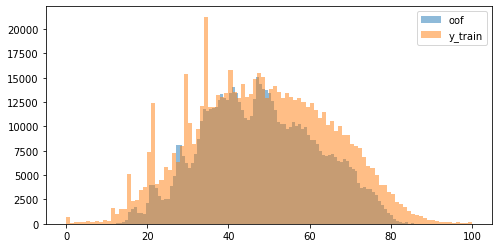

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[cv_idx[0][1][0]:], bins=100, label="oof", alpha=0.5)
plt.hist(y_train.iloc[cv_idx[0][1][0]:], bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[6.323012093292901, 6.4445633714756685, 6.456572257352367, 6.295051156032343, 6.700135708143853]
6.443866917259426


In [ ]:
print("=== score ===")
print(mean_absolute_error(oof_train[cv_idx[0][1][0]:], train.congestion.iloc[cv_idx[0][1][0]:]))

=== score ===
6.4438669172594505


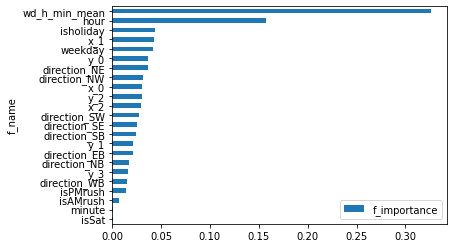

In [ ]:
f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=True)
df_importance.plot.barh(x="f_name")

### 実験2
実験2で効いてなさそうなminuteとisSatを削除

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [ ]:
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainデータをwide formatに変換
wide_train = pd.pivot(train, index="time", columns=["x", "y", "direction"], values="congestion")

# 曜日，時間，分のカラムを作成
wide_train = wide_train.reset_index()
wide_train["weekday"] = wide_train.time.dt.weekday
wide_train["hour"] = wide_train.time.dt.hour
wide_train["minute"] = wide_train.time.dt.minute

# 曜日，時間，分のループ用配列
weekdays = wide_train.weekday.unique()
hours = wide_train.hour.unique()
minutes = wide_train.minute.unique()

# 平均値の格納用配列 (あとでNaNを代入することになるのでfloat指定)
tmp = np.zeros_like(wide_train.loc[:, [0, 1, 2]]).astype("float")

# 曜日，時間，分の組み合わせでループして，各時点より過去のデータでの平均を計算
for wd, h, m in itertools.product(weekdays, hours, minutes):
    df = wide_train[(wide_train.weekday == wd) & (wide_train.hour == h) & (wide_train.minute == m)].loc[:, [0, 1, 2]]
    df = df.shift(1).cumsum() / np.repeat(np.arange(df.shape[0]).reshape((-1, 1)), df.shape[1], axis=1)
    tmp[df.index, :] = df.values

# "wd_h_min_mean"というカラムをtrain setに追加
tmp = pd.DataFrame(tmp, index=wide_train.time, columns=wide_train.columns[1:-3])
tmp = tmp.stack(["x", "y", "direction"])
tmp.name = "wd_h_min_mean"
train = train.merge(tmp, how="left", left_on=["time", "x", "y", "direction"], right_index=True)

In [ ]:
# train, testに時系列の特徴量を追加
us_holidays = holidays.US()

for df in [train, test]:
    df["hour"] = df.time.dt.hour
    df["minute"] = df.time.dt.minute
    df["weekday"] = df.time.dt.weekday
    df["isAMrush"] = ((6 <= df.hour) & (df.hour <= 10)).astype("int")
    df["isPMrush"] = ((15 <= df.hour) & (df.hour <= 20)).astype("int")
    df["isSat"] = (df.weekday == 5).astype("int")
    df["isholiday"] = (df.time.map(lambda x: x in us_holidays)).astype("int")

# test setのwd_h_min_meanを追加
tmp = train.groupby(["x", "y", "direction", "weekday", "hour", "minute"]).congestion.mean()
tmp.name = "wd_h_min_mean"
test = test.merge(tmp, how="left", left_on=["x", "y", "direction", "weekday", "hour", "minute"], right_index=True)

data = pd.concat([train, test])
data = pd.get_dummies(data, columns=["x", "y", "direction"])

train = data.iloc[:len(train)]
test = data.iloc[len(train):]
train = train[~train.wd_h_min_mean.isna()]

In [ ]:
X_train = train.drop(["time", "minute", "isSat", "congestion"], axis=1)
y_train = train["congestion"]
X_test = test.drop(["time", "minute", "isSat", "congestion"], axis=1)

In [ ]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 10.287	valid_1's l1: 10.1472
[20]	training's l1: 8.46044	valid_1's l1: 8.23888
[30]	training's l1: 7.56075	valid_1's l1: 7.2955
[40]	training's l1: 7.11681	valid_1's l1: 6.84164
[50]	training's l1: 6.88861	valid_1's l1: 6.62566
[60]	training's l1: 6.7537	valid_1's l1: 6.51419
[70]	training's l1: 6.67242	valid_1's l1: 6.46046
[80]	training's l1: 6.6222	valid_1's l1: 6.43324
[90]	training's l1: 6.58694	valid_1's l1: 6.42092
[100]	training's l1: 6.55431	valid_1's l1: 6.41056
[110]	training's l1: 6.52644	valid_1's l1: 6.4003
[120]	training's l1: 6.50132	valid_1's l1: 6.39191
[130]	training's l1: 6.48018	valid_1's l1: 6.38625
[140]	training's l1: 6.46036	valid_1's l1: 6.38053
[150]	training's l1: 6.44407	valid_1's l1: 6.37622
[160]	training's l1: 6.42931	valid_1's l1: 6.37278
[170]	training's l1: 6.4148	valid_1's l1: 6.36868
[180]	training's l1: 6.39912	valid_1's l1: 6.36457
[190]	tra

In [ ]:
with open("../output/y_preds_013-2.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_013-2.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_013-2.pkl", "wb") as f:
    pickle.dump(oof_train, f)

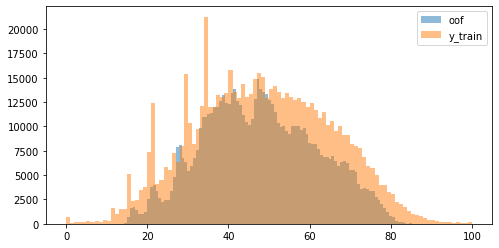

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[cv_idx[0][1][0]:], bins=100, label="oof", alpha=0.5)
plt.hist(y_train.iloc[cv_idx[0][1][0]:], bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[6.340270840654255, 6.44564761179938, 6.470560597685179, 6.299249280227076, 6.69796199865314]
6.450738065803806


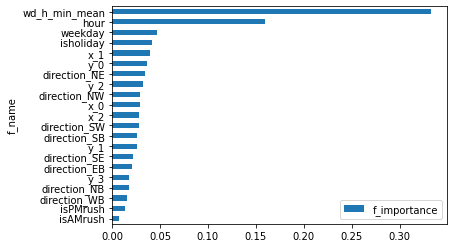

In [ ]:
f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=True)
df_importance.plot.barh(x="f_name")

### 実験3
実験1で使った平均との差を目的変数にしてlgbで回帰  
平均と差の予測値の和を取る

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [ ]:
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [ ]:
# trainデータをwide formatに変換
wide_train = pd.pivot(train, index="time", columns=["x", "y", "direction"], values="congestion")

# 曜日，時間，分のカラムを作成
wide_train = wide_train.reset_index()
wide_train["weekday"] = wide_train.time.dt.weekday
wide_train["hour"] = wide_train.time.dt.hour
wide_train["minute"] = wide_train.time.dt.minute

# 曜日，時間，分のループ用配列
weekdays = wide_train.weekday.unique()
hours = wide_train.hour.unique()
minutes = wide_train.minute.unique()

# 平均値の格納用配列 (あとでNaNを代入することになるのでfloat指定)
tmp = np.zeros_like(wide_train.loc[:, [0, 1, 2]]).astype("float")

# 曜日，時間，分の組み合わせでループして，各時点より過去のデータでの平均を計算
for wd, h, m in itertools.product(weekdays, hours, minutes):
    df = wide_train[(wide_train.weekday == wd) & (wide_train.hour == h) & (wide_train.minute == m)].loc[:, [0, 1, 2]]
    df = df.shift(1).cumsum() / np.repeat(np.arange(df.shape[0]).reshape((-1, 1)), df.shape[1], axis=1)
    tmp[df.index, :] = df.values

# "wd_h_min_mean"というカラムをtrain setに追加
tmp = pd.DataFrame(tmp, index=wide_train.time, columns=wide_train.columns[1:-3])
tmp = tmp.stack(["x", "y", "direction"])
tmp.name = "wd_h_min_mean"
train = train.merge(tmp, how="left", left_on=["time", "x", "y", "direction"], right_index=True)

In [ ]:
# train, testに時系列の特徴量を追加
us_holidays = holidays.US()

for df in [train, test]:
    df["hour"] = df.time.dt.hour
    df["minute"] = df.time.dt.minute
    df["weekday"] = df.time.dt.weekday
    df["isAMrush"] = ((6 <= df.hour) & (df.hour <= 10)).astype("int")
    df["isPMrush"] = ((15 <= df.hour) & (df.hour <= 20)).astype("int")
    df["isSat"] = (df.weekday == 5).astype("int")
    df["isholiday"] = (df.time.map(lambda x: x in us_holidays)).astype("int")

# test setのwd_h_min_meanを追加
tmp = train.groupby(["x", "y", "direction", "weekday", "hour", "minute"]).congestion.mean()
tmp.name = "wd_h_min_mean"
test = test.merge(tmp, how="left", left_on=["x", "y", "direction", "weekday", "hour", "minute"], right_index=True)

data = pd.concat([train, test])
data = pd.get_dummies(data, columns=["x", "y", "direction"])
data["diff"] = data.congestion - data.wd_h_min_mean

train = data.iloc[:len(train)]
test = data.iloc[len(train):]
train = train[~train.wd_h_min_mean.isna()]

In [ ]:
X_train = train.drop(["time", "congestion", "diff"], axis=1)
y_train = train["diff"]
X_test = test.drop(["time", "congestion", "diff"], axis=1)

In [ ]:
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = {}

cv = TimeSeriesSplit(n_splits=5)

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx[fold_idx] = [tr_idx, val_idx]
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 6.88347	valid_1's l1: 6.37297
[20]	training's l1: 6.79675	valid_1's l1: 6.37626
Early stopping, best iteration is:
[11]	training's l1: 6.87237	valid_1's l1: 6.37255
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 6.6097	valid_1's l1: 6.5473
[20]	training's l1: 6.56594	valid_1's l1: 6.54544
[30]	training's l1: 6.53744	valid_1's l1: 6.54555
[40]	training's l1: 6.51196	valid_1's l1: 6.54176
[50]	training's l1: 6.48891	valid_1's l1: 6.53544
[60]	training's l1: 6.46927	valid_1's l1: 6.53022
[70]	training's l1: 6.45162	valid_1's l1: 6.52324
[80]	training's l1: 6.43388	valid_1's l1: 6.51532
[90]	training's l1: 6.42055	valid_1's l1: 6.51122
[100]	training's l1: 6.40783	valid_1's l1: 6.50653
[110]	training's l1: 6.39653	valid_1's l1: 6.50336
[120]	training's l1: 6.3854	valid_1's l1: 6.50027
[130]	training's l1: 6.37479	valid_1's 

In [ ]:
oof_train = oof_train + train.wd_h_min_mean.values
y_preds = y_preds + test.wd_h_min_mean.values

In [ ]:
with open("../output/y_preds_013-3.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_013-3.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_013-3.pkl", "wb") as f:
    pickle.dump(oof_train, f)

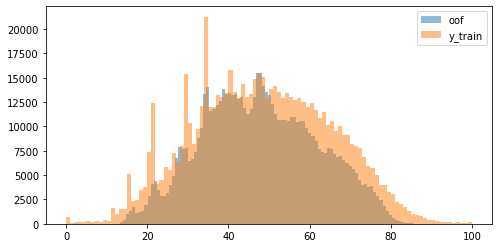

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[cv_idx[0][1][0]:], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[cv_idx[0][1][0]:].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[6.372551112968423, 6.435153978219277, 6.4530098625843735, 6.326677238181921, 6.70167316085738]
6.457813070562276


In [ ]:
print("=== score ===")
print(mean_absolute_error(oof_train[cv_idx[0][1][0]:], train.iloc[cv_idx[0][1][0]:].congestion))

=== score ===
6.457813070127537


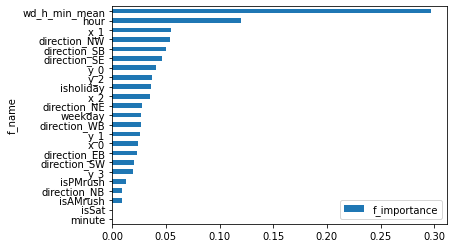

In [ ]:
f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=True)
df_importance.plot.barh(x="f_name")

### submit

In [ ]:
with open("../output/y_preds_013-1.pkl", "rb") as f:
    y_preds = pickle.load(f)

submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = y_preds[-1]

submission.to_csv("../submit/submission_013-1.csv", index=False)

In [ ]:
with open("../output/y_preds_013-3.pkl", "rb") as f:
    y_preds = pickle.load(f)

submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = y_preds[-1]

submission.to_csv("../submit/submission_013-3.csv", index=False)

In [ ]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

Kaggle API 1.5.12


In [ ]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_013-1.csv -m "013-1"

100% 57.5k/57.5k [00:00<00:00, 297kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022

In [ ]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_013-3.csv -m "013-3"

100% 57.6k/57.6k [00:00<00:00, 272kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022